In [1]:
import scipy.sparse as sps
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.constants import k

def BdG_Hamiltonian_Spin(n,  delta_in_list, T,  t =1, V =1, periodic = True):
  '''
  Função que preenche uma SciPy Sparse Matrix baseada
  no número de sítios e nas regras de formação para as
  diagonais do sistema em questão

  Argumentos:
  n: número de sítios(int)
  delta_in: gap superconductor(float)
  T: Temperatura do sistema(float)
  t: Termo de hopping(float)
  V: Parâmetro superconductor
  periodic: Periodic Boundary Conditions(Boolean)

  Return: Retorna a matriz sparsa construída
  '''

  #Preenche somente uma vez os termos de hopping triangularmente
  aux = 1
  if(aux == 1):
    rows, cols = 2*n, 2*n
    hopping = sps.dok_matrix((rows, cols))
    values = t*np.ones((n-1))
    values = np.append(values, 0)
    values = np.append(values, -values)
    hopping.setdiag(values, k=1)
    if (periodic == True):
      hopping[0,n-1] = t
      hopping[n,2*n-1] = -t

    aux = 0


  #Preenche os deltas triangularmente
  delta = sps.dok_matrix((rows, cols))
  b = delta_in_list
  delta.setdiag(b, k = n)
  '''if (periodic == True):
    delta[0,2*n-1] = delta_in
    delta[n,n-1] = -delta_in'''


  #Soma as duas matrizes
  f = delta + hopping

  #Prenche o triangulo inferior
  f = f.T + f

  return f

[[ 0.  1.  0.  1.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  2.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  3.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.  4.]
 [ 1.  0.  0.  0.  0. -1.  0. -1.]
 [ 0.  2.  0.  0. -1.  0. -1.  0.]
 [ 0.  0.  3.  0.  0. -1.  0. -1.]
 [ 0.  0.  0.  4. -1.  0. -1.  0.]]
[-4.37228132 -3.37228132 -2.37228132 -1.37228132  1.37228132  2.37228132
  3.37228132  4.37228132]


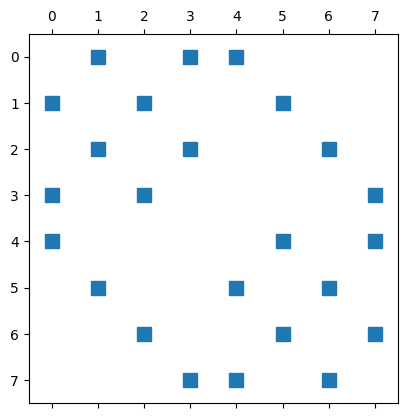

In [2]:
#Teste visualização

import matplotlib.pylab as plt
import scipy.sparse as sparse

import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

#BdG_Hamiltonian(n,  delta_in, T,  t =1, V =1, periodic = True)
delta_list = [i+1 for  i in range(4)]

A=BdG_Hamiltonian_Spin(n = 4, delta_in_list = delta_list, T = 0.5, t= 1, V = 0.1,periodic = True)
plt.spy(A)

print(A.toarray())
from scipy.linalg import eigh
eigenvals, eigenvecs = eigh(A.toarray())
print(eigenvals)

In [3]:
def gap_function(n, T_array, t=1, V=1, epsilon=1e-2, delta_guess = 1.0):
  '''
  Função que calcula o gap de um sistema de modo
  autoconsistente para uma lista de temperaturas

  Argumentos:
  n: número de sítios(int)
  T_array: lista de temperaturas do sistema(list of floats)
  t: Termo de hopping(float)
  V: Parâmetro superconductor(float)
  epsilon: Valor de convergência para a autoconsistência(float)

  Return: lista de valores de delta em função da temperatura
  '''
  delta_array = []
  delta_in = 1.0




  for i, T in enumerate(T_array):
    print(f"Computing delta for T = {T}...", delta_in)
    if i == 0:
      # Initial guess for the first temperature
      delta_in = delta_guess
    else:
      # Use the last computed delta as the initial guess for the next temperature
      delta_in = delta_array[i-1]

    # Compute the gap using self-consistent calculation
    c= 0
    delta_list = [1 for  i in range(n)]
    delta_in = [0 for  i in range(n)]

    while True:
      sparse = BdG_Hamiltonian_Spin(n, t=t, delta_in_list=delta_list, V=V, T=T, periodic = True)
      eigenvalues, eigenvectors = eigh(sparse.toarray())
      #print(sparse.toarray())
      for i in range(n):
        delta_next = 0.0
        for j in range(n):
          u, v = np.split(eigenvectors[:, j], 2)
          delta_next += V * v[i] * u[i] * np.tanh(eigenvalues[j] / (2*k*T))
        print(delta_next, delta_in[j])


        delta_list[j] = delta_next
        '''print(delta_list)
        print("in")
        print(delta_in)'''



      epsilon =2*max(eigenvalues)*np.exp(-1/(1045*V))/100

      conditions = []

      # Add conditions dynamically
      for i in range(n):
        print(i)
        conditions.append(abs(delta_list[i] - delta_in[i]) < epsilon)

        '''print((abs(delta_list[i] - delta_in[i])))
        print("delta")
        print(delta_list[i],  delta_in[i])'''

      # Check if all conditions are true
      if all(conditions):
        print("condition")
        delta_list = delta_in.copy()  # Copy the updated values back to delta_list
        break
      else:
        delta_list = delta_in.copy()  # Copy the updated values back to delta_list

    delta_array.append(delta_list)

  print(epsilon)
  print(eigenvalues)
  return delta_array


In [29]:
def gap_function(n, T_array, t=1, V=1, epsilon=1e-2, delta_guess=1.0):
    delta_array = []
    delta_in = 1.0

    for i, T in enumerate(T_array):
        print(f"Computing delta for T = {T}...", delta_in)

        if i == 0:
            # Initial guess for the first temperature
            delta_in = delta_guess
        else:
            # Use the last computed delta as the initial guess for the next temperature
            delta_in = delta_array[i-1]

        # Compute the gap using self-consistent calculation
        delta_list = [1 for _ in range(n)]  # Initial delta list
        delta_next_list = [0 for _ in range(n)]  # Delta list for updating values

        while True:
            sparse = BdG_Hamiltonian_Spin(n, t=t, delta_in_list=delta_list, V=V, T=T, periodic=False)
            eigenvalues, eigenvectors = eigh(sparse.toarray())

            for j in range(n):
                delta_next = 0.0
                for k in range(n):
                    u, v = np.split(eigenvectors[:, k], 2)
                    delta_next += V * v[j] * u[j] * np.tanh(eigenvalues[k] / (2 * k * T))

                delta_next_list[j] = delta_next  # Store the updated delta value in delta_next_list

            epsilon = 2 * max(eigenvalues) * np.exp(-1 / (1045 * V)) /1000

            conditions = []
            for j in range(n):
                conditions.append((abs(delta_next_list[j] - delta_list[j])) < epsilon)

            if all(conditions):
                print("condition")
                delta_list = delta_next_list.copy()  # Copy the updated values back to delta_list
                break
            else:
                delta_list = delta_next_list.copy()  # Copy the updated values back to delta_list

        delta_array.append(delta_list)

    print(epsilon)
    print(eigenvalues)
    return delta_array


Computing delta for T = 0.1... 1.0


<ipython-input-29-39d2d261cb16>:27: RuntimeWarning: divide by zero encountered in double_scalars
  delta_next += V * v[j] * u[j] * np.tanh(eigenvalues[k] / (2 * k * T))


condition
Computing delta for T = 1.2000000000000002... 1.0
condition
Computing delta for T = 2.3000000000000003... [0.004621773825667774, -0.01899550869819722, 0.04112218471467353, -0.06641464808948846, 0.08807396280617628, -0.09972469674544746, 0.09957552878649978, -0.09129295469419474, 0.08005079694099314, -0.07040330829230451, 0.0646407608460548, -0.06261765869176922, 0.06268150991629366, -0.06299960877150569, 0.06197429582551, -0.05891487280333088, 0.054025429256076965, -0.048087632273627084, 0.04215429158904164, -0.037355245415102274, 0.03443682191177188, -0.033641578983061075, 0.03475126014996722, -0.037310963947466615, 0.0408117802549932, -0.04479020143064629, 0.048761445122326795, -0.052289783535427806, 0.055081456797842994, -0.05711125153374438, 0.058580510774619114, -0.05970093239590998, 0.06054551928103585, -0.061123568877775626, 0.061406073287117745, -0.061420078974106576, 0.06127554585411481, -0.06100897990939282, 0.06060516984471197, -0.060172131595436794, 0.059792286751

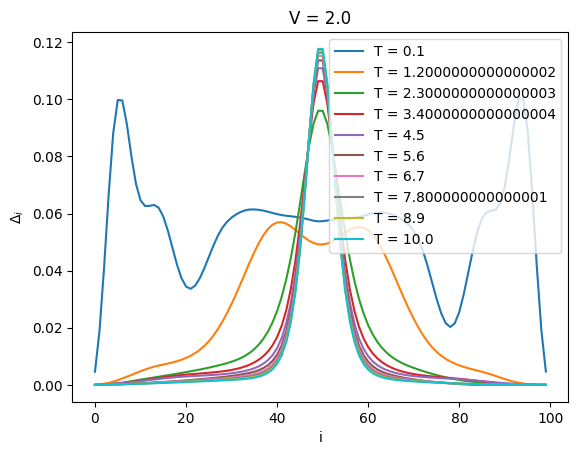

Computing delta for T = 0.1... 1.0
condition
Computing delta for T = 1.2000000000000002... 1.0
condition
Computing delta for T = 2.3000000000000003... [0.01713762074454563, -0.03987861045671377, 0.04701086949397304, -0.059034165834273074, 0.07314780298526427, -0.25051442082536696, 4.480935640345135, -0.4010936559693373, 4.421786287027441, -0.4021736271622201, 4.42203474376669, -0.4018282916858581, 4.474702262816064, -0.356034234071461, 0.4989975640824892, -0.7055256414944463, 0.6598504320186707, -0.5648911612190504, 0.4569990740368108, -0.350735968670238, 0.26815578004684226, -0.23424968969783252, 0.2475577900262984, -0.2674596049356937, 0.29353929886833546, -0.31725793259004964, 0.3586242584403076, -0.3851023509987722, 0.2974537380609177, -0.34024545990867167, 3.8406294124937186, -0.4437321321081797, 4.405637226299449, -0.4168936405183047, 4.229895973891426, -0.41920185511085384, 4.444771854828811, -0.2981627478666215, 0.20982215922505507, -0.38155034595919907, 3.2715700030595136, -0.

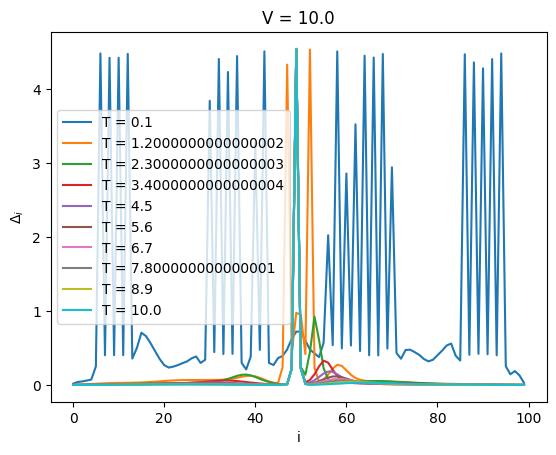

Computing delta for T = 0.1... 1.0
condition
Computing delta for T = 1.2000000000000002... 1.0
condition
Computing delta for T = 2.3000000000000003... [-0.029400706837856443, 0.04557852704450426, 0.1331165740977183, -0.3859033339418789, 0.5367905366012699, -0.2677003351427635, 10.816027193209225, -0.16818735340582475, 12.351437572136602, 5.529474650865801, 12.385933079042177, 9.808412992382385, 12.399630275444473, 10.215379279572376, 12.40006618222964, 9.065080099586442, 12.400071982143787, 8.488008008052878, 10.39993201360841, 9.317562944377789, 11.170867234151652, 4.879262308860164, 11.694775168977769, 2.168280407715773, 12.275913079357798, -0.15786885252463775, 12.2450088763313, -0.16109030841432886, 11.852164910597486, -0.1612631439092227, 12.300552983799504, -0.1556166826958354, 12.261729486749056, -0.15627403176532334, 12.254679479563531, -0.15408470267639016, 12.307049696965093, -0.16093862437936404, 11.361949225681311, -0.1607369695772857, 12.296022625684325, -0.153694396266094

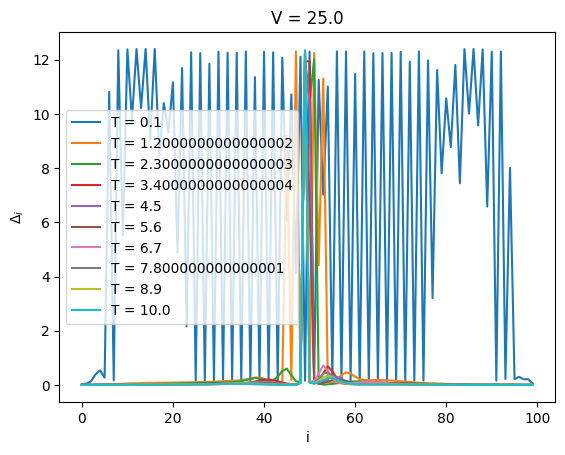

Computing delta for T = 0.1... 1.0
condition
Computing delta for T = 1.2000000000000002... 1.0
condition
Computing delta for T = 2.3000000000000003... [49.34149387496387, 49.36848771600787, 49.46528718269454, 49.4949776211009, 49.57653391779876, 49.60281816436694, 49.97929715770876, 49.670363161997194, 49.9788467299378, 49.97919529265618, 49.978337858908546, 49.978388411293984, 49.978028373700596, 49.97689496000419, 49.97784437086388, 49.975089291524775, 49.977729139872054, 49.97407648507733, 49.97766175814272, 49.971954803120575, 49.97760637088923, 49.95914328013516, 49.97754625262333, 49.93989070891595, 49.97746357922673, 49.8138137849685, 49.97737793690089, 49.936868396234686, 49.97727362189341, 49.86896289204631, 49.9771221772439, 49.85466113153066, 49.976994781028644, 49.75320868965675, 49.97695167265942, 49.780750477104846, 49.97696572437486, 49.861599086063016, 49.97697327994879, 49.97866706215531, 49.976929351164905, 49.73271582421197, 49.97689304412085, 49.82545095274087, 49.9

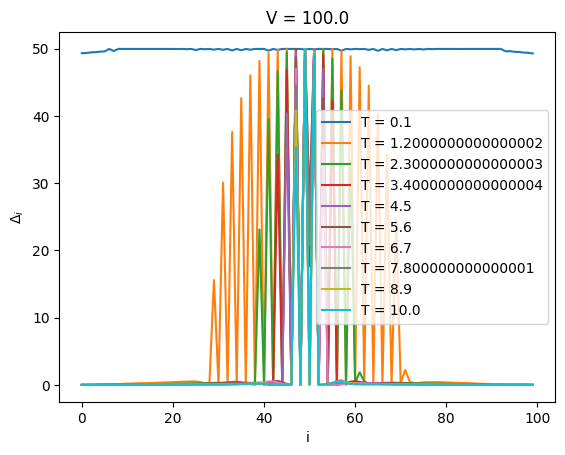

Computing delta for T = 0.1... 1.0
condition
Computing delta for T = 1.2000000000000002... 1.0
condition
Computing delta for T = 2.3000000000000003... [499.99899999984416, 499.99800000074026, 499.998000001868, 499.99800000195546, 499.9980000019739, 499.99800000198286, 499.9980000019878, 499.99800000198996, 499.9980000019926, 499.99800000199417, 499.9980000019946, 499.9980000019948, 499.9980000019951, 499.99800000199525, 499.9980000019946, 499.99800000199497, 499.9980000019947, 499.99800000199485, 499.998000001995, 499.9980000019948, 499.99800000199457, 499.99800000199474, 499.9980000019945, 499.9980000019942, 499.99800000199394, 499.9980000019932, 499.99800000199355, 499.9980000019941, 499.9980000019941, 499.99800000199366, 499.9980000019938, 499.99800000199355, 499.99800000199286, 499.99800000199195, 499.99800000199224, 499.99800000199247, 499.99800000199286, 499.99800000199383, 499.99800000199394, 499.99800000199434, 499.9980000019936, 499.9980000019923, 499.9980000019924, 499.998000

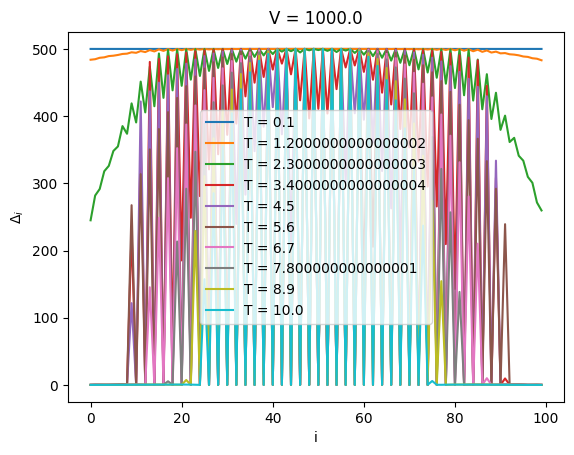

In [76]:
from scipy.constants import k
import matplotlib.pyplot as plt
k=1.0
T_array = np.linspace(0.1, 10, 2)
t= 1.0
V_array = [2*t, 10*t, 25*t, 100*t, 1000*t]
n = 100

for V in V_array:
  k=1.0
  T_array = np.linspace(0.1, 10, 10)
  t= 1.0
  n = 100
  delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)
  delta_array = np.array(delta_array)
  for i, c in enumerate(delta_array):
    T = T_array[i]
    plt.plot(abs(c), label = 'T = {T}'.format(T = T))
    plt.title('V = {V}'.format(V = V))
    plt.xlabel('i')
    plt.ylabel(r'$\Delta_{i}$')
    plt.legend()
  plt.show()



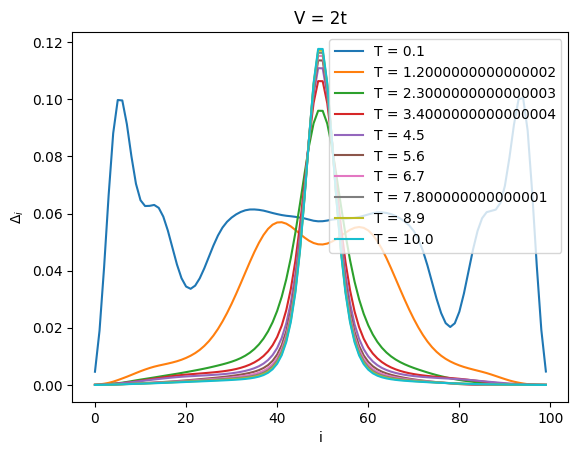

In [72]:
delta_array = np.array(delta_array)
for i, c in enumerate(delta_array):
  T = T_array[i]
  plt.plot(abs(c), label = 'T = {T}'.format(T = T))
  plt.title('V = 2t')
  plt.xlabel('i')
  plt.ylabel(r'$\Delta_{i}$')
  plt.legend()

In [ ]:

k=1.0
T_array = np.linspace(0.1, 10, 2)
t= 1.0
V_array = [2*t, 10*t, 25*t 100*t, 1000*t]
n = 100
for V in V_array:
  delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)
  plt.scatter(range(len(delta_array[0])),np.abs(np.round(delta_array[0], 4)), label = V)
  plt.xlabel('i')
  plt.ylabel(r'$\Delta_{i}$')
  plt.legend()
plt.show()

In [ ]:
k=1.0
T_array = np.linspace(0.1, 10, )
t= 1.0
V = 2*t
n = 100
delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)
plt.scatter(range(len(delta_array[0])),np.abs(np.round(delta_array[0], 4)), label = V)
plt.xlabel('i')
plt.ylabel(r'$\Delta_{i}$')
plt.legend()
plt.show()

In [27]:
delta_array = np.array(delta_array)
delta_array.shape
delta_array[1]

array([-7.78237966e-03,  3.44749217e-02, -5.97303095e-02,  7.55458200e-02,
       -9.45669744e-02,  1.16527730e-01, -1.31827225e-01,  1.52032419e-01,
       -1.86206844e-01,  2.28335411e-01, -2.64339685e-01,  2.91332144e-01,
       -3.18783877e-01,  3.58263122e-01, -4.00937214e-01,  4.30642388e-01,
       -4.57826780e-01,  4.90411713e-01, -5.22580249e-01,  5.49576022e-01,
       -5.49168017e-01,  5.33119553e-01, -4.61136234e-01,  2.78081578e-01,
       -7.68884243e-02,  1.57295774e+02, -9.99614479e-03,  2.85288714e+02,
       -6.33437882e-03,  3.55200261e+02, -5.29649416e-03,  4.04323089e+02,
       -4.75298868e-03,  4.39861505e+02, -4.42827277e-03,  4.65201851e+02,
       -4.22772705e-03,  4.82353380e+02, -4.10701721e-03,  4.92807878e+02,
       -4.04171667e-03,  4.98021193e+02, -4.01342371e-03,  4.99754733e+02,
       -4.00548315e-03,  4.99995788e+02, -4.00449730e-03,  4.99995116e+02,
       -4.00452062e-03,  4.99994370e+02, -4.00457332e-03,  4.99995119e+02,
       -4.00459796e-03,  

In [ ]:
#data generating
from scipy.constants import k
import matplotlib.pyplot as plt


k = 0.0861733
T_array = np.linspace(0.01, 310, 100)
V_array = np.linspace(25, 100, 50)
N_array = [10,25,50,100]
#data = np.stack((delta_array, T_array, n*np.ones(len(T_array)), V*np.ones(len(T_array))), axis = 1)
for n in N_array:
  for V in V_array:
    delta_array = gap_function(n=int(n), T_array=T_array, V = V)
    new_data = np.stack((delta_array, T_array, n*np.ones(len(T_array)), V*np.ones( len(T_array))), axis = 1)
    data = np.vstack((new_data, data))



A saída de streaming foi truncada nas últimas 5000 linhas.
Computing delta for T = 144.04575757575756... 44.04765596234439
Computing delta for T = 147.1769696969697... 43.81411510704648
Computing delta for T = 150.30818181818182... 43.564041739506486
Computing delta for T = 153.43939393939394... 43.30155058096068
Computing delta for T = 156.57060606060605... 43.027284622442224
Computing delta for T = 159.70181818181817... 42.73628813225954
Computing delta for T = 162.8330303030303... 42.42708082908671
Computing delta for T = 165.96424242424243... 42.10630197481584
Computing delta for T = 169.09545454545454... 41.76820720491548
Computing delta for T = 172.22666666666666... 41.41088541262277
Computing delta for T = 175.35787878787878... 41.0407256579956
Computing delta for T = 178.48909090909092... 40.64980884788714
Computing delta for T = 181.62030303030303... 40.242447090085065
Computing delta for T = 184.75151515151515... 39.81986438998571
Computing delta for T = 187.88272727272727...

In [ ]:
len(data)

40100

In [ ]:
-np.log(92.04/(2*130.87))*1000

1045.1283794601693

(array([3765., 1166., 4526., 6226., 7055., 6921., 7632., 7331., 7873.,
        7605.]),
 array([-0.2712995 ,  9.75483125, 19.78096199, 29.80709274, 39.83322349,
        49.85935423, 59.88548498, 69.91161573, 79.93774647, 89.96387722,
        99.99000796]),
 <BarContainer object of 10 artists>)

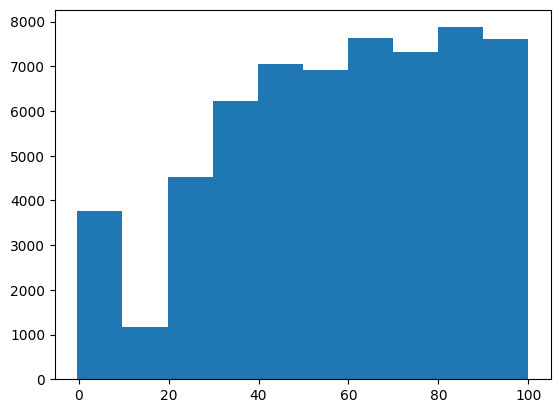

In [ ]:
plt.hist(Y)

N(0) = 1045.13

$$\Delta = 2ħ ω_C exp(\frac{-1}{N(0)V})$$

Computing delta for T = 0.01... 1.0
Computing delta for T = 100.0... 99.98999721562431
0.02000574467245359
[-2.00059361 -2.00011249 -2.00010885 ...  2.00010885  2.00011249
  2.00059361]
[99.98999721562431, 0.010991067048901093]


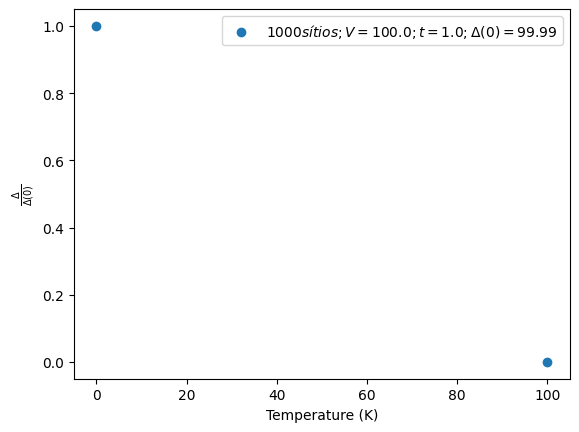

In [ ]:
from scipy.constants import k
import matplotlib.pyplot as plt

#k = 0.0861733
k=1.0
T_array = np.linspace(1e-2, 100, 2)
t=1.0
V = 100*t
n = 1000
delta_array = gap_function(n=n, T_array=T_array, V = V, t = t, epsilon=1e-2)

print(delta_array)


plt.scatter(T_array, abs(delta_array/delta_array[0]),
            label =r"${} sítios; V = {}; t = {}; \Delta(0) = {:.2f}$" .format(n, V, t, delta_array[0]))
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\frac{\Delta}{\Delta(0)}$')
plt.legend()
plt.show()